In [1]:
import numpy as np
np.random.seed(0) # The module employed for intergrating the SDEs does not seem to respect the random seed.
                  # Documentation of sdeint indicates it should respect the seed.
                  # Reproducibility of the exact figures (especially 3 and S1) may be compromised.
import importlib
import sdeint
importlib.reload(sdeint)
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib
import time
from matplotlib.patches import Rectangle
import seaborn as sns
import KM_EWS_methods
importlib.reload(KM_EWS_methods)


<module 'KM_EWS_methods' from '/Users/andreasmorr/Library/Mobile Documents/com~apple~CloudDocs/PhD Studium/Eigene Papers/KramersMoyalEWS/KramersMoyalEWS/KM_EWS_methods.py'>

Plot specifications

In [2]:
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.serif': ['Helvetica'],
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})
measurecolor = "black"
samplecolor = "black"
errorcolor = "grey"
theocolor = "red"
theocolor2 = "darkorange"
pcolor = "black" #"#015d91"
zcolor = "grey" #"#ed8302"
eigval1color = "#4daf4a"
eigval2color = "#984ea3"
kmcolorrange = matplotlib.colormaps["cool"]
samplelinewidth = 2*1
errorlinewidth = 2*0.7
theolinewidth = 2*1
equillinewidth = 2*0.8
confidenceinterval = 0.68

Define the parameters and functions of the fold bifurcation

In [3]:
samplesize = 1000 # number of sample paths to perform estimations on
T = 1000 # length of the time series in units of time
OneOverDelta_t = 10 # Delta_t is the sampling time step of the time series
Delta_t = 1/OneOverDelta_t
oversampling = 10 # the SDE integration is done at a time step which is oversampling* finer than the sampling time step.
int_tspan = np.linspace(0, T, T * OneOverDelta_t * oversampling,endpoint=False)
plt_tspan = np.linspace(0, T, T * OneOverDelta_t,endpoint=False)
alpha_0 = 1 # start of bifurcation parameter evolution
alpha_T = -0.1 # end of bifurcation parameter evolution
sigma_0 = 0.2 # start of noise strength parameter evolution
sigma_T = 0.06 # end of noise strength parameter evolution
T_measure = round((alpha_0 - 0.1) / (alpha_0 - alpha_T) * T) # time span for estimations to exclude noise tipping
T_posalpha = round(alpha_0 / (alpha_0 - alpha_T) * T) # time span for theoretical estimator values (for linear \alpha evolution)
x_0 = np.array([alpha_0**(0.5)]) # initial value of the SDE integration
x_off = -2 # x state after bifurcation


# bifurcation parameter evolution
def alpha(t):
    return alpha_0 * (1 - t/T) + alpha_T * t/T

# noise strength parameter evolution
def sigma(t):
    return sigma_0*(1-t/T)+sigma_T*t/T

# fold bifurcation normal form
def f(x,t):
    if x[0]>x_off / 2:
        return np.array([-(x[0])**2 + alpha(t)])
    else:
        return -(x[0] - x_off)

# noise strength matrix
def G(x,t):
    return np.array([[sigma(t)]])

# linearised restoring force in x dimension, specifically for fold bifurcation
def lambda_x(alpha):
    return 2 * np.sqrt(alpha)

Integrate a collection of sample paths

In [4]:
samplepaths = []
for i in range(samplesize):
    integration = sdeint.itoint(f,G,x_0,int_tspan)
    samplepaths.append(np.transpose(integration[::oversampling]))

Define the theoretical functions for the variance and lag-1 autocorrelation of the observable as functions of the linear restoring rate $\lambda_x$. Also define the theoretical fixed points as a function of the parameter $\alpha$.

In [5]:
def theovar(t):
    return G([theoxfix(alpha(t))],t)[0,0]**2/(2*lambda_x(alpha(t)))

def theoac1(t):
    return np.exp(-lambda_x(alpha(t))*Delta_t)

def theoxfix(alpha):
    if alpha >= 0:
        return np.sqrt(alpha)
    else:
        return x_off


Define estimation constraints

In [6]:
windowsize = 100 * OneOverDelta_t # estimation windowsize in units of individual data points sampled at time step Delta_t
leap = 10 * OneOverDelta_t # leap between sucessive estimations in units of individual data points sampled at time step Delta_t
kmleapfactor = 10 # skip this many KM visualisations in the color plots
number_of_windows = (T_measure * OneOverDelta_t - windowsize)// leap # number of estimation windows resulting
colorsteps = round(number_of_windows/kmleapfactor)+1 # number of disjoint colored estiamtion windows resulting

Calculate conventional EWS

In [7]:
samplevars = []
sampleac1s = []
for i in range(samplesize):
    samplevars.append([])
    sampleac1s.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        samplevars[i].append(KM_EWS_methods.variance_estimator(samplepaths[i][0][j: j + windowsize]))
        sampleac1s[i].append(KM_EWS_methods.ac1_estimator(samplepaths[i][0][j: j + windowsize]))
samplevars = np.array(samplevars)
sampleac1s = np.array(sampleac1s)

meansamplevar = np.mean(samplevars, axis = 0)
meansampleac1 = np.mean(sampleac1s, axis = 0)

lowersamplevar = np.array([np.sort(samplevars[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(samplevars[0]))])
lowersampleac1 = np.array([np.sort(sampleac1s[:,j])[round((0.5-confidenceinterval/2)*samplesize)-1] for j in range(len(sampleac1s[0]))])
                         
uppersamplevar = np.array([np.sort(samplevars[:,j])[round((0.5+confidenceinterval/2)*samplesize)] for j in range(len(samplevars[0]))])
uppersampleac1 = np.array([np.sort(sampleac1s[:,j])[round((0.5+confidenceinterval/2)*samplesize)-1] for j in range(len(sampleac1s[0]))])

Calculate KM coefficients

In [8]:
sampleedges = []
samplea = []
sampleb = []
samplelambdas = []
for i in range(samplesize):
    sampleedges.append([])
    samplea.append([])
    sampleb.append([])
    samplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        km_analysis_results = KM_EWS_methods.full_km_analysis_1D(samplepaths[i][0][j: j + windowsize], Delta_t) # See more specifics in the file KM_EWS_methods.py
        sampleedges[i].append(km_analysis_results[0])
        samplea[i].append(km_analysis_results[1])
        sampleb[i].append(km_analysis_results[2])
        samplelambdas[i].append(km_analysis_results[3])


sampleedges = np.array(sampleedges)
samplea = np.array(samplea)
sampleb = np.array(sampleb)
samplelambdas = np.array(samplelambdas)

meansamplelambda = np.mean(samplelambdas, axis = 0)

lowersamplelambda = np.array([np.sort(samplelambdas[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(samplelambdas[0]))])
                         
uppersamplelambda = np.array([np.sort(samplelambdas[:,j])[round((0.5+confidenceinterval/2)*samplesize)-1] for j in range(len(samplelambdas[0]))])

Plot KM coefficients

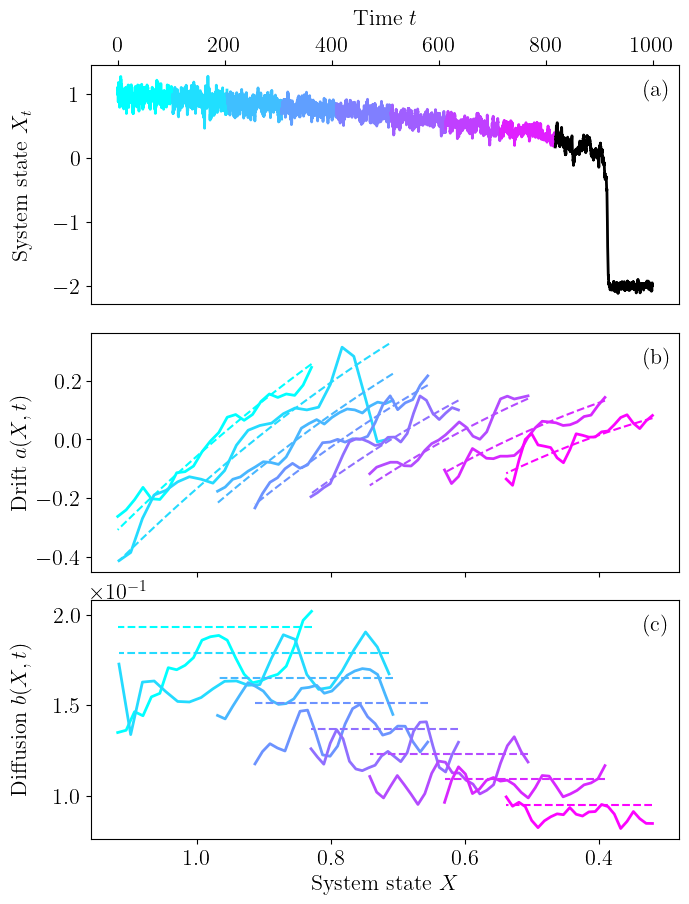

In [9]:
fig, [xplt, aplt, bplt] = plt.subplots(nrows=3, ncols=1,figsize=(2*3.42, 2*4.5), gridspec_kw={'height_ratios': [1, 1, 1]})

props = dict(edgecolor="none", facecolor='white', alpha=0)
for k in range(colorsteps):
    xplt.plot(plt_tspan[k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)],samplepaths[0][0][k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)], color = kmcolorrange(k/colorsteps), linewidth = samplelinewidth)
xplt.plot(plt_tspan[T_measure*OneOverDelta_t:],samplepaths[0][0][T_measure*OneOverDelta_t:], color = samplecolor, linewidth = samplelinewidth)
xplt.xaxis.tick_top()
xplt.xaxis.set_label_position("top")
xplt.set_ylabel("System state $X_t$")
xplt.set_xlabel("Time $t$", labelpad=8)
xplt.text(0.94, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
for j in range(0,number_of_windows,kmleapfactor):
    aplt.plot(sampleedges[0][j], samplea[0][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)
    aplt.plot(sampleedges[0][j], [f([x],plt_tspan[j*leap+windowsize//2])[0] for x in sampleedges[0][j]],linestyle = "dashed", color = kmcolorrange(j/number_of_windows))
aplt.set_ylabel("Drift $a(X,t)$")
aplt.text(0.94, 0.94, "(b)", transform=aplt.transAxes, verticalalignment='top', bbox=props)
aplt.set_xticklabels([])
aplt.set_xlim(aplt.get_xlim()[1],aplt.get_xlim()[0])
for j in range(0,number_of_windows,kmleapfactor):
    bplt.plot(sampleedges[0][j], sampleb[0][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)  
    bplt.plot(sampleedges[0][j], [G([x],plt_tspan[j*leap+windowsize//2])[0,0] for x in sampleedges[0][j]], linestyle = "dashed", color = kmcolorrange(j/number_of_windows))
bplt.set_ylabel("Diffusion $b(X,t)$")
bplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
bplt.text(0.94, 0.94, "(c)", transform=bplt.transAxes, verticalalignment='top', bbox=props)
bplt.set_xlim(bplt.get_xlim()[1],bplt.get_xlim()[0])
#bplt.set_yticks([.5,1.0,1.5,2.0])
#bplt.set_xticks(bplt.get_xticks(),np.round(-bplt.get_xticks(),2))
bplt.set_xlabel("System state $X$")
#bplt.text(0.0,1.02, r'$\times 10^{-2}$', transform=bplt.transAxes)

[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xplt, aplt, bplt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.93, hspace=.12, wspace=.2)
#fig.savefig("Plots/FoldObservableKM" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")

/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_46147/2835719207.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  alphaxplt.set_xticklabels([round(alpha(t),2) for t in xplt.get_xticks()])


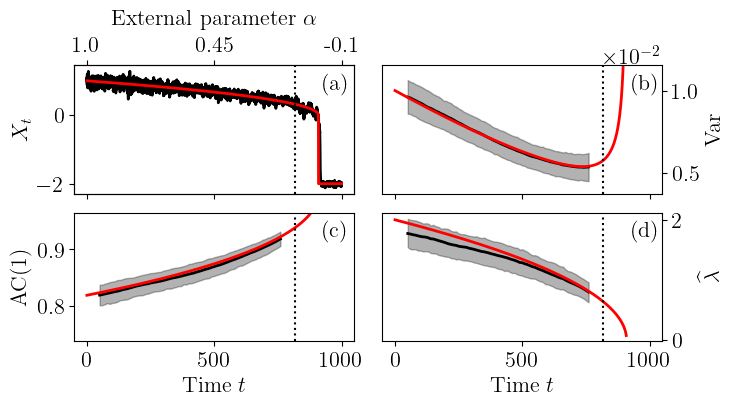

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(3.42*2, 1.5*2),sharex=True)#1*2), sharex=True)
[xplt, varplt, ac1plt, lambdaplt] = axs.flatten()
props = dict(edgecolor="none", facecolor='white', alpha=0)
xplt.plot(plt_tspan, samplepaths[0][0], color = samplecolor, linewidth = samplelinewidth)
xplt.plot(plt_tspan,[theoxfix(alpha(t)) for t in plt_tspan], color = theocolor, linewidth = theolinewidth)
xplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
xplt.set_ylabel("$X_t$")
#xplt.text(0.1, 0.2, "$X_t$", transform=xplt.transAxes, verticalalignment='top', bbox=props)
xplt.text(0.89, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
alphaxplt = xplt.twiny()
alphaxplt.set_xlim(xplt.get_xlim())
alphaxplt.set_xticklabels([round(alpha(t),2) for t in xplt.get_xticks()])
alphaxplt.set_xlabel(r"External parameter $\alpha$", labelpad=8)
varplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowersamplevar, uppersamplevar, color=samplecolor, alpha = 0.3)
varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplevar, color = samplecolor, linewidth = theolinewidth)
varplt.plot([theovar(t) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
varplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
varplt.set_ylabel("Var")
varplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
varplt.set_ylim([0.7 * min(meansamplevar), 1.2 * max(meansamplevar)])
varplt.yaxis.tick_right()
#varplt.text(0.1, 0.2, "Variance", transform=varplt.transAxes, verticalalignment='top', bbox=props)
varplt.text(0.89, 0.94, "(b)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
#alphavarplt = varplt.twiny()
#alphavarplt.set_xlim(xplt.get_xlim())
#alphavarplt.set_xticklabels([])
ac1plt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowersampleac1, uppersampleac1, color=samplecolor, alpha = 0.3)
ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansampleac1, color = samplecolor, linewidth = theolinewidth)
ac1plt.plot([theoac1(t) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
ac1plt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
ac1plt.set_ylabel("AC(1)")
ac1plt.set_ylim([0.9 * min(meansampleac1), 1.05 * max(meansampleac1)])
#ac1plt.text(0.1, 0.2, "AC(1)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
ac1plt.text(0.89, 0.94, "(c)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
ac1plt.set_xlabel("Time $t$")
#alphaac1plt = ac1plt.twiny()
#alphaac1plt.set_xlim(xplt.get_xlim())
#alphaac1plt.set_xticklabels([])
lambdaplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowersamplelambda, uppersamplelambda, color=samplecolor, alpha = 0.3)
lambdaplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda, color = samplecolor, linewidth = theolinewidth)
lambdaplt.plot([lambda_x(alpha(t)) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
lambdaplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
lambdaplt.set_ylabel("$\widehat{\lambda}$")
#lambdaplt.text(0.1, 0.2, "$\widehat\lambda$", transform=lambdaplt.transAxes, verticalalignment='top', bbox=props)
lambdaplt.text(0.89, 0.94, "(d)", transform=lambdaplt.transAxes, verticalalignment='top', bbox=props)
lambdaplt.yaxis.tick_right()
#alphalamplt = lambdaplt.twiny()
#alphalamplt.set_xlim(xplt.get_xlim())
#alphalamplt.set_xticklabels([])
lambdaplt.set_xlabel("Time $t$")

[plots.yaxis.set_label_coords(-0.15,.5) for plots in [xplt, ac1plt]]
[plots.yaxis.set_label_coords(1.22,.5) for plots in [varplt, lambdaplt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.15, wspace=.1)
#fig.savefig("Plots/FoldVarAC1Lam" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")

Single figure

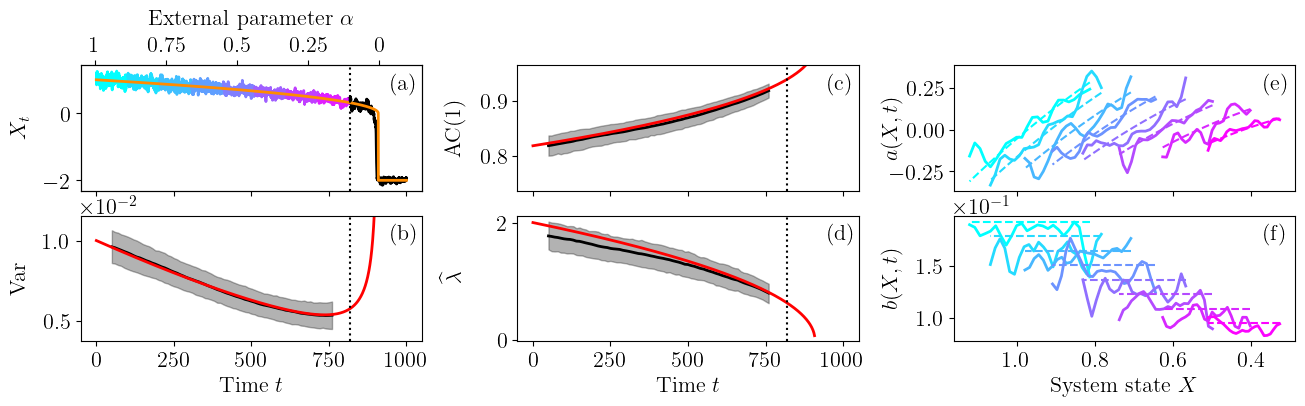

In [22]:
show_sample = 9
fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(7.06*2, 1.5*2),sharex="col")#3.42*2,1*2
[xplt, ac1plt, aplt, varplt, lambdaplt, bplt] = axs.flatten()
props = dict(edgecolor="none", facecolor='white', alpha=0)
props2 = dict(edgecolor="black", facecolor='white', alpha=1)
for k in range(colorsteps):
    xplt.plot(plt_tspan[k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)],samplepaths[show_sample][0][k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)], color = kmcolorrange(k/colorsteps), linewidth = samplelinewidth)
xplt.plot(plt_tspan[T_measure*OneOverDelta_t:],samplepaths[show_sample][0][T_measure*OneOverDelta_t:], color = samplecolor, linewidth = samplelinewidth)
xplt.plot(plt_tspan,[theoxfix(alpha(t)) for t in plt_tspan], color = theocolor2, linewidth = theolinewidth)
xplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
xplt.set_ylabel("$X_t$")
#xplt.text(0.1, 0.25, "$X_t$", transform=xplt.transAxes, verticalalignment='top', bbox=props2)
xplt.text(0.91, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
alphaxplt = xplt.twiny()
alphaxplt.set_xlabel(r"External parameter $\alpha$", labelpad=8)
varplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowersamplevar, uppersamplevar, color=samplecolor, alpha = 0.3)
varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplevar, color = samplecolor, linewidth = theolinewidth)
varplt.plot([theovar(t) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
varplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)

varplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
varplt.set_ylim([0.7 * min(meansamplevar), 1.2 * max(meansamplevar)])
#varplt.yaxis.tick_right()
varplt.set_ylabel("Var")
#varplt.text(0.1, 0.25, "Var", transform=varplt.transAxes, verticalalignment='top', bbox=props2)
varplt.text(0.91, 0.94, "(b)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
varplt.set_xlabel("Time $t$")
#alphavarplt = varplt.twiny()
#alphavarplt.set_xlim(xplt.get_xlim())
#alphavarplt.set_xticklabels([])
ac1plt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowersampleac1, uppersampleac1, color=samplecolor, alpha = 0.3)
ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansampleac1, color = samplecolor, linewidth = theolinewidth)
ac1plt.plot([theoac1(t) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
ac1plt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
ac1plt.set_ylim([0.9 * min(meansampleac1), 1.05 * max(meansampleac1)])
ac1plt.set_ylabel("AC(1)")
#ac1plt.text(0.1, 0.25, "AC(1)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props2)
ac1plt.text(0.91, 0.94, "(c)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
#alphaac1plt = ac1plt.twiny()
#alphaac1plt.set_xlim(xplt.get_xlim())
#alphaac1plt.set_xticklabels([])
lambdaplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowersamplelambda, uppersamplelambda, color=samplecolor, alpha = 0.3)
lambdaplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meansamplelambda, color = samplecolor, linewidth = theolinewidth)
lambdaplt.plot([lambda_x(alpha(t)) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
lambdaplt.scatter(1000,1,c="white")
lambdaplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
lambdaplt.set_ylabel("$\widehat{\lambda}$")
#lambdaplt.text(0.1, 0.25, "$\lambda$", transform=lambdaplt.transAxes, verticalalignment='top', bbox=props2)
lambdaplt.text(0.91, 0.94, "(d)", transform=lambdaplt.transAxes, verticalalignment='top', bbox=props)
#lambdaplt.yaxis.tick_right()
#alphalamplt = lambdaplt.twiny()
#alphalamplt.set_xlim(xplt.get_xlim())
#alphalamplt.set_xticklabels([])
lambdaplt.set_xlabel("Time $t$")

for j in range(0,number_of_windows,kmleapfactor):
    aplt.plot(sampleedges[show_sample][j], samplea[show_sample][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)
    aplt.plot(sampleedges[show_sample][j], [f([x],plt_tspan[j*leap+windowsize//2])[0] for x in sampleedges[show_sample][j]],linestyle = "dashed", color = kmcolorrange(j/number_of_windows))
aplt.set_ylabel("$a(X,t)$")
#bplt.text(0.7, 0.25, "$a(X,t)$", transform=aplt.transAxes, verticalalignment='top', bbox=props2)
aplt.text(0.91, 0.94, "(e)", transform=aplt.transAxes, verticalalignment='top', bbox=props)
#aplt.set_xticklabels([])
aplt.set_xlim(aplt.get_xlim()[1],aplt.get_xlim()[0])
for j in range(0,number_of_windows,kmleapfactor):
    bplt.plot(sampleedges[show_sample][j], sampleb[show_sample][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)  
    bplt.plot(sampleedges[show_sample][j], [G([x],plt_tspan[j*leap+windowsize//2])[0,0] for x in sampleedges[show_sample][j]], linestyle = "dashed", color = kmcolorrange(j/number_of_windows))
bplt.set_ylabel("$b(X,t)$")
#bplt.text(0.1, 0.25, "$b(X,t)$", transform=bplt.transAxes, verticalalignment='top', bbox=props2)
bplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
bplt.text(0.91, 0.94, "(f)", transform=bplt.transAxes, verticalalignment='top', bbox=props)
#bplt.set_xlim(bplt.get_xlim()[1],bplt.get_xlim()[0])
#bplt.set_yticks([.5,1.0,1.5,2.0])
#bplt.set_xticks(bplt.get_xticks(),np.round(-bplt.get_xticks(),2))
bplt.set_xlabel("System state $X$")
#bplt.text(0.0,1.02, r'$\times 10^{-2}$', transform=bplt.transAxes)

[plots.yaxis.set_label_coords(-0.15,.5) for plots in [xplt, varplt, aplt, ac1plt, lambdaplt, bplt]]
#[plots.yaxis.set_label_coords(-0.15,.5) for plots in [xplt, ac1plt]]
#[plots.yaxis.set_label_coords(1.22,.5) for plots in [varplt, lambdaplt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.2, wspace=.28)

alphaxplt.set_xlim([1.05,-0.15])
alphaxplt.set_xticks([1,0.75,0.5,0.25,0])
alphaxplt.set_xticklabels(["1","0.75","0.5","0.25","0"])
#alphaxplt.set_xticklabels([round(alpha(t),2) for t in xplt.get_xticks()])
#fig.savefig("Plots/FoldVarAC1Lam" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")

Define the Predator Prey Model

In [54]:
samplesize = 1000 # number of sample paths to perform estimations on
T = 1000 # length of the time series in units of time
prerun = 10 # time to allow for equilibration of the system
OneOverDelta_t = 50 # Delta_t is the sampling time step of the time series
Delta_t = 1/OneOverDelta_t
oversampling = 10 # the SDE integration is done at a time step which is oversampling* finer than the sampling time step.
int_tspan = np.linspace(-prerun, T, (T+prerun) * OneOverDelta_t*oversampling,endpoint=False)
plt_tspan = np.linspace(0, T, T * OneOverDelta_t,endpoint=False)
turb_0 = 2.2/2.2 # start of bifurcation parameter evolution
turb_T = 0.71/2.2 # end of bifurcation parameter evolution
T_measure = round(0.8*T)# time span for estimations (for linear \turb evolution)
T_posturb = round(turb_0 / (turb_0 - turb_T) * T) # time span for theoretical estimator values (for linear \turb evolution)
pz_0 = np.array([0.62,2.1]) # initial value of the SDE integration

sigma_p = 0.037
sigma_z = 0.01

r = 1
a = 1/9
m_z = 0.0525
xi = 0.7
h_0 = 1/16
c_h = 0.4*2.2
K_0 = 0.7
c_K = 0.3*2.2

p_scaling = 1

# bifurcation parameter evolution
def turb(t):
    return turb_0 * (1 - t/T) + turb_T * t/T


def h(turb):
    return h_0/(1+turb*c_h)


def g(p,turb):
    return a*p**2/(h(turb)**2+p**2)


def K(turb):
    return K_0+turb*c_K

# deterministic evolution, fold bifurcation normal form
def f(pz,t):
    return np.array([xi**-1*(r*(pz[0]/p_scaling)*(1-(pz[0]/p_scaling)/K(turb(t)))-g((pz[0]/p_scaling),turb(t))*pz[1]),g((pz[0]/p_scaling),turb(t))*pz[1]-m_z*pz[1]**2])


# noise strength matrix
def G(pz,t):
    return np.array([[xi**-0.5 * sigma_p * pz[0],0],[0,sigma_z * pz[1]]])

Integrate a collection of sample paths

In [13]:
ppsamplepaths = []
for i in range(samplesize):
    integration = sdeint.itoint(f,G,pz_0,int_tspan)
    ppsamplepaths.append(np.transpose(integration[prerun*OneOverDelta_t*oversampling::oversampling]))


Calculate the bifurcation diagram of the system

In [14]:
lowerst = [optimize.root(f,x0=[0.05,1],args=(k)).x[0] for k in range(T)]
midunst = [optimize.root(f,x0=[0.4,2],args=(k)).x[0] for k in range(T)]
midst = [optimize.root(f,x0=[1,2],args=(k)).x[0] for k in range(T)]

Define estimation constraints

In [15]:
windowsize = 100 * OneOverDelta_t # estimation windowsize in units of individual data points sampled at time step Delta_t
zwindowsize = windowsize # set longer windowsize for z to account fow much slower dynamics and thus slower estimator convergence
leap = 10 * OneOverDelta_t # leap between sucessive estimations in units of individual data points sampled at time step Delta_t
kmleapfactor = 10 # skip this many KM visualisations in the color plots
number_of_windows = (T_measure * OneOverDelta_t - windowsize)// leap # number of estimation windows resulting
colorsteps = round(number_of_windows/kmleapfactor)+1 # number of disjoint colored estiamtion windows resulting

Calculate conventional EWS

In [16]:
psamplevars = []
psampleac1s = []
for i in range(samplesize):
    psamplevars.append([])
    psampleac1s.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        psamplevars[i].append(KM_EWS_methods.variance_estimator(ppsamplepaths[i][0][j: j + windowsize]))
        psampleac1s[i].append(KM_EWS_methods.ac1_estimator(ppsamplepaths[i][0][j: j + windowsize]))
psamplevars = np.array(psamplevars)
psampleac1s = np.array(psampleac1s)

meanpsamplevar = np.mean(psamplevars, axis = 0)
meanpsampleac1 = np.mean(psampleac1s, axis = 0)

#lowerpsamplevar = np.array([np.sort(psamplevars[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(psamplevars[0]))])
#lowerpsampleac1 = np.array([np.sort(psampleac1s[:,j])[round((0.5-confidenceinterval/2)*samplesize)-1] for j in range(len(psampleac1s[0]))])
                         
#upperpsamplevar = np.array([np.sort(psamplevars[:,j])[round((0.5+confidenceinterval/2)*samplesize)] for j in range(len(psamplevars[0]))])
#upperpsampleac1 = np.array([np.sort(psampleac1s[:,j])[round((0.5+confidenceinterval/2)*samplesize)-1] for j in range(len(psampleac1s[0]))])



zsamplevars = []
zsampleac1s = []
for i in range(samplesize):
    zsamplevars.append([])
    zsampleac1s.append([])
    for j in range(0,T_measure * OneOverDelta_t-zwindowsize,leap):
        zsamplevars[i].append(KM_EWS_methods.variance_estimator(ppsamplepaths[i][1][j: j + zwindowsize]))
        zsampleac1s[i].append(KM_EWS_methods.ac1_estimator(ppsamplepaths[i][1][j: j + zwindowsize]))
zsamplevars = np.array(zsamplevars)
zsampleac1s = np.array(zsampleac1s)

meanzsamplevar = np.mean(zsamplevars, axis = 0)
meanzsampleac1 = np.mean(zsampleac1s, axis = 0)

#lowerzsamplevar = np.array([np.sort(zsamplevars[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(zsamplevars[0]))])
#lowerzsampleac1 = np.array([np.sort(zsampleac1s[:,j])[round((0.5-confidenceinterval/2)*samplesize)-1] for j in range(len(zsampleac1s[0]))])
                         
#upperzsamplevar = np.array([np.sort(zsamplevars[:,j])[round((0.5+confidenceinterval/2)*samplesize)] for j in range(len(zsamplevars[0]))])
#upperzsampleac1 = np.array([np.sort(zsampleac1s[:,j])[round((0.5+confidenceinterval/2)*samplesize)-1] for j in range(len(zsampleac1s[0]))])

Calculate KM coefficients

In [17]:
psampleedges = []
psamplea = []
psampleb = []
psamplelambdas = []
for i in range(samplesize):
    psampleedges.append([])
    psamplea.append([])
    psampleb.append([])
    psamplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        km_analysis_results = KM_EWS_methods.full_km_analysis_1D(ppsamplepaths[i][0][j: j + windowsize], Delta_t) # See more specifics in the file KM_EWS_methods.py
        psampleedges[i].append(km_analysis_results[0])
        psamplea[i].append(km_analysis_results[1])
        psampleb[i].append(km_analysis_results[2])
        psamplelambdas[i].append(km_analysis_results[3])


psampleedges = np.array(psampleedges)
psamplea = np.array(psamplea)
psampleb = np.array(psampleb)
psamplelambdas = np.array(psamplelambdas)

meanpsamplelambda = np.mean(psamplelambdas, axis = 0)

#lowerpsamplelambda = np.array([np.sort(psamplelambdas[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(psamplelambdas[0]))])
                         
#upperpsamplelambda = np.array([np.sort(psamplelambdas[:,j])[round((0.5+confidenceinterval/2)*samplesize)-1] for j in range(len(psamplelambdas[0]))])



zsampleedges = []
zsamplea = []
zsampleb = []
zsamplelambdas = []
for i in range(samplesize):
    zsampleedges.append([])
    zsamplea.append([])
    zsampleb.append([])
    zsamplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-zwindowsize,leap):
        km_analysis_results = KM_EWS_methods.full_km_analysis_1D(ppsamplepaths[i][1][j: j + zwindowsize], Delta_t) # See more specifics in the file KM_EWS_methods.py
        zsampleedges[i].append(km_analysis_results[0])
        zsamplea[i].append(km_analysis_results[1])
        zsampleb[i].append(km_analysis_results[2])
        zsamplelambdas[i].append(km_analysis_results[3])


zsampleedges = np.array(zsampleedges)
zsamplea = np.array(zsamplea)
zsampleb = np.array(zsampleb)
zsamplelambdas = np.array(zsamplelambdas)

meanzsamplelambda = np.mean(zsamplelambdas, axis = 0)

#lowerzsamplelambda = np.array([np.sort(zsamplelambdas[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(zsamplelambdas[0]))])
                         
#upperzsamplelambda = np.array([np.sort(zsamplelambdas[:,j])[round((0.5+confidenceinterval/2)*samplesize)-1] for j in range(len(zsamplelambdas[0]))])

Perform 2D drift analysis

In [18]:
d2samplelambdas = []
for i in range(samplesize):
    d2samplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        d2samplelambdas[i].append(KM_EWS_methods.lambda_estimator(ppsamplepaths[i][:,j: j + windowsize], Delta_t, bin_number=50)) # See more specifics in the file KM_EWS_methods.py


d2samplelambdas = np.array(d2samplelambdas)

meand2samplelambda = np.mean(d2samplelambdas, axis = 0)

#lowerd2samplelambda = np.array([[np.sort(d2samplelambdas[:,j,0])[round((0.5-confidenceinterval/2)*samplesize)],np.sort(d2samplelambdas[:,j,1])[round((0.5-confidenceinterval/2)*samplesize)]] for j in range(len(d2samplelambdas[0]))])
                         
#upperd2samplelambda = np.array([[np.sort(d2samplelambdas[:,j,0])[round((0.5+confidenceinterval/2)*samplesize)],np.sort(d2samplelambdas[:,j,1])[round((0.5+confidenceinterval/2)*samplesize)]] for j in range(len(d2samplelambdas[0]))])

Plot KM coefficients

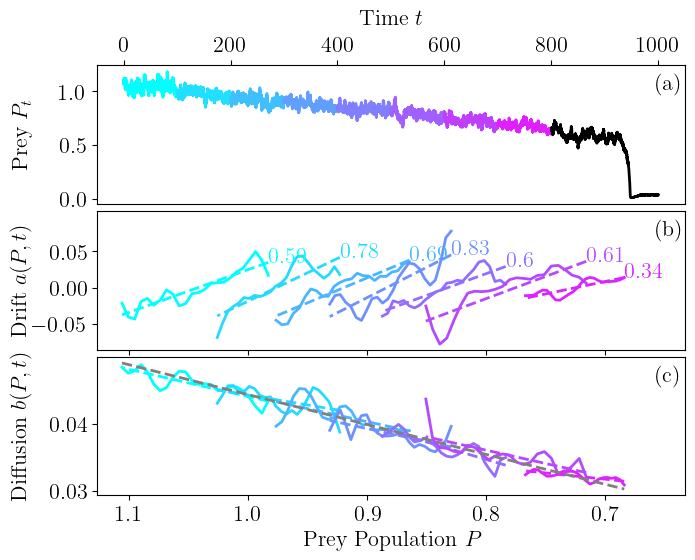

In [19]:
display_sample = 1

fig, [xplt, aplt, bplt] = plt.subplots(nrows=3, ncols=1,figsize=(3.42*2, 2.5*2), gridspec_kw={'height_ratios': [1, 1, 1]})

props = dict(edgecolor="none", facecolor='white', alpha=0)
for k in range(colorsteps):
    xplt.plot(plt_tspan[k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)],ppsamplepaths[display_sample][0][k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)], color = kmcolorrange(k/colorsteps), linewidth = samplelinewidth)
xplt.plot(plt_tspan[T_measure*OneOverDelta_t:],ppsamplepaths[display_sample][0][T_measure*OneOverDelta_t:], color = samplecolor, linewidth = samplelinewidth)
xplt.xaxis.tick_top()
xplt.xaxis.set_label_position("top")
xplt.set_xlabel("Time $t$", labelpad=8)
xplt.set_ylabel("Prey $P_t$")
xplt.text(0.95, 0.94, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
for j in range(0,number_of_windows,kmleapfactor):
    m_fit, b_fit = np.polyfit(psampleedges[display_sample][j], psamplea[display_sample][j], 1)
    aplt.plot(psampleedges[display_sample][j], m_fit*psampleedges[display_sample][j]+b_fit, color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth, linestyle = "dashed")
    aplt.text(psampleedges[display_sample][j][0], m_fit*psampleedges[display_sample][j][0]+b_fit+0.0, str(round(psamplelambdas[display_sample][j],2)),color=kmcolorrange(j/number_of_windows))
    aplt.plot(psampleedges[display_sample][j], psamplea[display_sample][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)
aplt.set_ylabel("Drift $a(P,t)$")
aplt.text(0.95, 0.94, "(b)", transform=aplt.transAxes, verticalalignment='top', bbox=props)
aplt.set_xticklabels([])
aplt.set_yticks([-0.05,0,0.05])
aplt.set_xlim(aplt.get_xlim()[1],aplt.get_xlim()[0]-0.03)
aplt.set_ylim(aplt.get_ylim()[0],aplt.get_ylim()[1]+0.02)
for j in range(0,number_of_windows,kmleapfactor):
    m_fit, b_fit = np.polyfit(psampleedges[display_sample][j], psampleb[display_sample][j], 1)
    bplt.plot(psampleedges[display_sample][j], m_fit*psampleedges[display_sample][j]+b_fit, color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth, linestyle = "dashed")
    bplt.plot(psampleedges[display_sample][j], psampleb[display_sample][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)  
m_fit, b_fit = np.polyfit(psampleedges[display_sample].flatten(), psampleb[display_sample].flatten(), 1)
bplt.plot(np.array([max(psampleedges[display_sample][::kmleapfactor].flatten()),min(psampleedges[display_sample][::kmleapfactor].flatten())]), m_fit*np.array([max(psampleedges[display_sample][::kmleapfactor].flatten()),min(psampleedges[display_sample][::kmleapfactor].flatten())])+b_fit, color = "grey", linewidth = theolinewidth, linestyle = "dashed")
bplt.set_ylabel("Diffusion $b(P,t)$")
#bplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
bplt.text(0.95, 0.94, "(c)", transform=bplt.transAxes, verticalalignment='top', bbox=props)
bplt.set_xlim(aplt.get_xlim()[0],aplt.get_xlim()[1])
#bplt.set_xticks(bplt.get_xticks(),np.round(-bplt.get_xticks(),2))
bplt.set_xlabel("Prey Population $P$")

#bplt.set_yticks([.6,.8,1.0,1.2,1.4])
#bplt.set_xticks(bplt.get_xticks(),np.round(-bplt.get_xticks(),2))
#bplt.text(0.0,1.02, r'$\times 10^{-2}$', transform=bplt.transAxes)

[plots.yaxis.set_label_coords(-0.11,.5) for plots in [xplt, aplt, bplt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.93, hspace=.05, wspace=.2)
#fig.savefig("Plots/PPKM" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")

/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_4688/3191317773.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  turbxplt.set_xticklabels([round(turb(t),2) for t in xplt.get_xticks()])


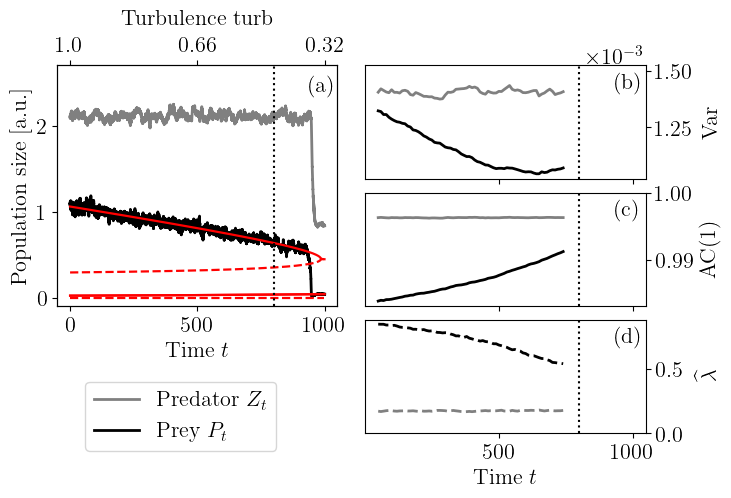

In [20]:
fig = plt.figure(figsize=(3.42*2,2*2))#1.2*2))
gs = fig.add_gridspec(3,2)
xplt = fig.add_subplot(gs[0:2,0])
varplt = fig.add_subplot(gs[0,1])
ac1plt = fig.add_subplot(gs[1,1])
lambdad2plt = fig.add_subplot(gs[2,1])
hiddenplt = fig.add_subplot(gs[2,0])
props = dict(edgecolor="none", facecolor='white', alpha=0)

xplt.plot(plt_tspan, ppsamplepaths[display_sample][1], color = zcolor, linewidth = samplelinewidth)
xplt.plot(plt_tspan, ppsamplepaths[display_sample][0], color = pcolor, linewidth = samplelinewidth)
xplt.plot(lowerst, color = theocolor, linewidth = equillinewidth)
xplt.plot(np.zeros(T), color = theocolor, linewidth = equillinewidth, linestyle = "dashed")
xplt.plot(lowerst, color = theocolor, linewidth = equillinewidth)
xplt.plot(midunst, color = theocolor, linewidth = equillinewidth, linestyle = "dashed")
xplt.plot(midst, color = theocolor, linewidth = equillinewidth)
xplt.set_ylabel("Population size [a.u.]")
xplt.legend(["Predator $Z_t$", "Prey $P_t$"], loc=(0.1,-0.6))
xplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
#xplt.text(0.03, 0.7, "Population size [a.u.]", transform=xplt.transAxes, verticalalignment='top', bbox=props)
xplt.text(0.9, 0.96, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
xplt.set_xlabel("Time $t$")
xplt.set_ylim(-0.1,2.7)
turbxplt = xplt.twiny()
turbxplt.set_xlim(xplt.get_xlim())
turbxplt.set_xticklabels([round(turb(t),2) for t in xplt.get_xticks()])
turbxplt.set_xlabel(r"Turbulence turb", labelpad=8)

#varplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerpsamplevar, upperpsamplevar, color=pcolor,alpha=0.3)
varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanpsamplevar, color = pcolor, linewidth = theolinewidth)
#varplt.fill_between(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerzsamplevar, upperzsamplevar, color=zcolor,alpha=0.3)
varplt.plot(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanzsamplevar, color = zcolor, linewidth = theolinewidth)
varplt.scatter([1000],[0.0015],color="white")
varplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
varplt.set_ylabel("Var")
varplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
varplt.yaxis.tick_right()
#varplt.set_ylim([0.7 * min(meansamplevar), 1.2 * max(meansamplevar)])
#varplt.text(0.1, 0.5, "Variance", transform=varplt.transAxes, verticalalignment='top', bbox=props)
varplt.text(0.89, 0.94, "(b)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
varplt.set_xticklabels([])
#turbvarplt = varplt.twiny()
#turbvarplt.set_xlim(xplt.get_xlim())
#turbvarplt.set_xticklabels([])
#ac1plt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerpsampleac1, upperpsampleac1, color=pcolor,alpha=0.3)
ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanpsampleac1, color = pcolor, linewidth = theolinewidth)
#ac1plt.fill_between(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerzsampleac1, upperzsampleac1, color=zcolor,alpha=0.3)
ac1plt.plot(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanzsampleac1, color = zcolor, linewidth = theolinewidth)
ac1plt.scatter([1000],[0.999],color="white")
ac1plt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
ac1plt.set_ylim(ac1plt.get_ylim()[0],1)
ac1plt.yaxis.tick_right()
ac1plt.set_xticklabels([])
ac1plt.set_yticks([0.99,1])
ac1plt.set_yticklabels(["0.99","1.00"])
ac1plt.set_ylabel("AC(1)")
#ac1plt.set_ylim([0.99 * min(meansampleac1), 1.01 * max(meansampleac1)])
#ac1plt.text(0.1, 0.5, "AC(1)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
ac1plt.text(0.89, 0.94, "(c)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
#turbac1plt = ac1plt.twiny()
#turbac1plt.set_xlim(xplt.get_xlim())
#turbac1plt.set_xticklabels([])
#lambdad2plt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerd2samplelambda[:,0], upperd2samplelambda[:,0], color=eigval1color,alpha=0.3)
lambdad2plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meand2samplelambda[:,0], color = pcolor, linewidth = theolinewidth, linestyle = "dashed")
#lambdad2plt.fill_between(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerd2samplelambda[:,1], upperd2samplelambda[:,1], color=eigval2color,alpha=0.3)
lambdad2plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meand2samplelambda[:,1], color = zcolor, linewidth = theolinewidth, linestyle = "dashed")
lambdad2plt.scatter([1000],[0.5],color="white")
lambdad2plt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
lambdad2plt.set_ylim(0,lambdad2plt.get_ylim()[1])
lambdad2plt.yaxis.tick_right()
lambdad2plt.set_ylabel(r"$\widehat{\lambda}$")
#lambdad2plt.text(0.1, 0.5, "$\widehat\lambda$", transform=lambdad2plt.transAxes, verticalalignment='top', bbox=props)
lambdad2plt.text(0.89, 0.94, "(d)", transform=lambdad2plt.transAxes, verticalalignment='top', bbox=props)
#turblamplt = lambdad2plt.twiny()
#turblamplt.set_xlim(xplt.get_xlim())
#turblamplt.set_xticklabels([])
lambdad2plt.set_xlabel("Time $t$")

hiddenplt.axis("off")
xplt.yaxis.set_label_coords(-0.09,0.5)
[plots.yaxis.set_label_coords(1.27,.5) for plots in [varplt, ac1plt, lambdad2plt]]

fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.12, wspace=.1)
xplt.yaxis.labelpad = 100
#fig.savefig("Plots/PPVarAC1linLam" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")

Combined plot

/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_4688/3573418239.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  turbxplt.set_xticklabels([round(turb(t),2) for t in [0, 0,250,500,750,1000]])


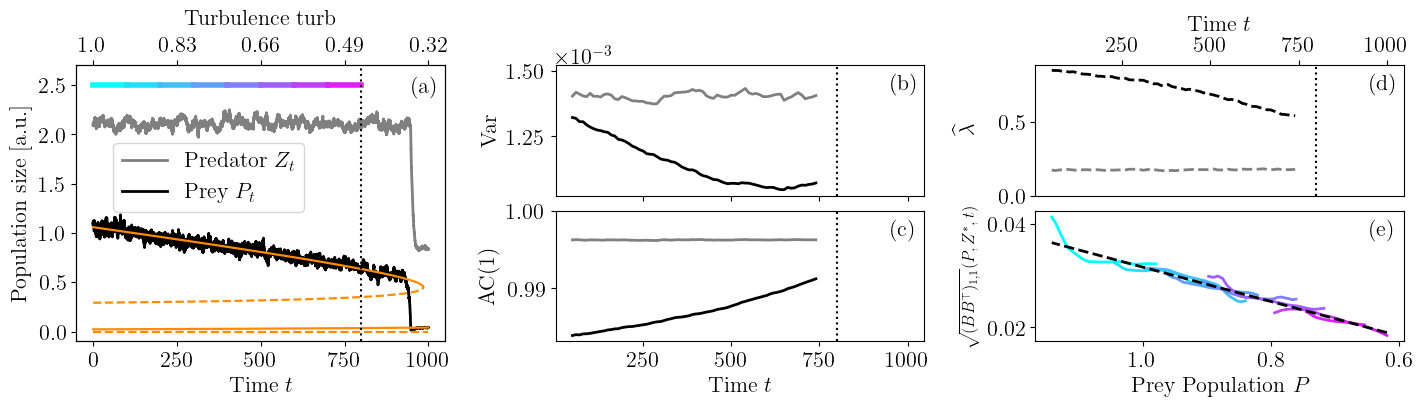

In [67]:
importlib.reload(KM_EWS_methods)
display_sample = 1
fig = plt.figure(figsize=(7.06*2,1.5*2))#1.2*2))
gs = fig.add_gridspec(2,3)
xplt = fig.add_subplot(gs[0:2,0])
varplt = fig.add_subplot(gs[0,1])
ac1plt = fig.add_subplot(gs[1,1])
lambdad2plt = fig.add_subplot(gs[0,2])
bplt = fig.add_subplot(gs[1,2])
#hiddenplt = fig.add_subplot(gs[3,0])
props = dict(edgecolor="none", facecolor='white', alpha=0)

xplt.plot(plt_tspan, ppsamplepaths[display_sample][1], color = zcolor, linewidth = samplelinewidth)
xplt.plot(plt_tspan, ppsamplepaths[display_sample][0], color = pcolor, linewidth = samplelinewidth)
#xplt.plot(lowerst, color = theocolor2, linewidth = equillinewidth)
xplt.plot(np.zeros(T), color = theocolor2, linewidth = equillinewidth, linestyle = "dashed")
xplt.plot(lowerst, color = theocolor2, linewidth = equillinewidth)
xplt.plot(midunst[:-14], color = theocolor2, linewidth = equillinewidth, linestyle = "dashed")
xplt.plot(midst[:-14], color = theocolor2, linewidth = equillinewidth)
for k in range(colorsteps):
    xplt.plot([plt_tspan[k*round(T_measure*OneOverDelta_t/colorsteps)],plt_tspan[(k+1)*round(T_measure*OneOverDelta_t/colorsteps)]],[2.5,2.5], color = kmcolorrange(k/colorsteps), linewidth = 2*samplelinewidth)
xplt.set_ylabel("Population size [a.u.]")
xplt.legend(["Predator $Z_t$", "Prey $P_t$"], loc=(0.1,0.47))
xplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
#xplt.text(0.03, 0.7, "Population size [a.u.]", transform=xplt.transAxes, verticalalignment='top', bbox=props)
xplt.text(0.91, 0.96, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
xplt.set_xlabel("Time $t$")
xplt.set_ylim(-0.1,2.7)

turbxplt = xplt.twiny()
turbxplt.scatter([0,1000],[1.5,1.5],c="white")
#turbxplt.set_xlim(xplt.get_xlim())
#print(xplt.get_xticklabels())
turbxplt.set_xticklabels([round(turb(t),2) for t in [0, 0,250,500,750,1000]])
turbxplt.set_xlabel(r"Turbulence turb", labelpad=8)

#varplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerpsamplevar, upperpsamplevar, color=pcolor,alpha=0.3)
varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanpsamplevar, color = pcolor, linewidth = theolinewidth)
#varplt.fill_between(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerzsamplevar, upperzsamplevar, color=zcolor,alpha=0.3)
varplt.plot(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanzsamplevar, color = zcolor, linewidth = theolinewidth)
varplt.scatter([1000],[0.0015],color="white")
varplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
varplt.set_ylabel("Var")
varplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
#varplt.yaxis.tick_right()
#varplt.set_ylim([0.7 * min(meansamplevar), 1.2 * max(meansamplevar)])
#varplt.text(0.1, 0.5, "Variance", transform=varplt.transAxes, verticalalignment='top', bbox=props)
varplt.text(0.91, 0.94, "(b)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
varplt.set_xticklabels([])
#turbvarplt = varplt.twiny()
#turbvarplt.set_xlim(xplt.get_xlim())
#turbvarplt.set_xticklabels([])
#ac1plt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerpsampleac1, upperpsampleac1, color=pcolor,alpha=0.3)
ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanpsampleac1, color = pcolor, linewidth = theolinewidth)
#ac1plt.fill_between(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerzsampleac1, upperzsampleac1, color=zcolor,alpha=0.3)
ac1plt.plot(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanzsampleac1, color = zcolor, linewidth = theolinewidth)
ac1plt.scatter([1000],[0.999],color="white")
ac1plt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
ac1plt.set_ylim(ac1plt.get_ylim()[0],1)
#ac1plt.yaxis.tick_right()
#ac1plt.set_xticklabels([])
ac1plt.set_yticks([0.99,1])
ac1plt.set_yticklabels(["0.99","1.00"])
ac1plt.set_ylabel("AC(1)")
ac1plt.set_xlabel("Time $t$")
#ac1plt.set_ylim([0.99 * min(meansampleac1), 1.01 * max(meansampleac1)])
#ac1plt.text(0.1, 0.5, "AC(1)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
ac1plt.text(0.91, 0.94, "(c)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
#turbac1plt = ac1plt.twiny()
#turbac1plt.set_xlim(xplt.get_xlim())
#turbac1plt.set_xticklabels([])
#lambdad2plt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerd2samplelambda[:,0], upperd2samplelambda[:,0], color=eigval1color,alpha=0.3)
lambdad2plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meand2samplelambda[:,0], color = pcolor, linewidth = theolinewidth, linestyle = "dashed")
#lambdad2plt.fill_between(range(round(zwindowsize/OneOverDelta_t / 2), T_measure - round(zwindowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerd2samplelambda[:,1], upperd2samplelambda[:,1], color=eigval2color,alpha=0.3)
lambdad2plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meand2samplelambda[:,1], color = zcolor, linewidth = theolinewidth, linestyle = "dashed")
lambdad2plt.scatter([1000],[0.5],color="white")
lambdad2plt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
lambdad2plt.set_ylim(0,lambdad2plt.get_ylim()[1])
#lambdad2plt.yaxis.tick_right()
lambdad2plt.set_ylabel(r"$\widehat{\lambda}$")
#lambdad2plt.text(0.1, 0.5, "$\widehat\lambda$", transform=lambdad2plt.transAxes, verticalalignment='top', bbox=props)
lambdad2plt.text(0.91, 0.94, "(d)", transform=lambdad2plt.transAxes, verticalalignment='top', bbox=props)
#turblamplt = lambdad2plt.twiny()
#turblamplt.set_xlim(xplt.get_xlim())
#turblamplt.set_xticklabels([])
lambdad2plt.set_xlabel(r"Time $t$")
lambdad2plt.xaxis.tick_top()
lambdad2plt.xaxis.set_label_position('top')
#lambdad2plt.xaxis.set_label_coords(0.5,0.5)

alledges = np.array([])
allBB11 = np.array([])
for k in range(colorsteps):
    [thisedges, thisBB11] = KM_EWS_methods.B11_km_analysis_2D(ppsamplepaths[display_sample][:,k*round(T_measure*OneOverDelta_t/colorsteps):(k+1)*round(T_measure*OneOverDelta_t/colorsteps)], Delta_t, bin_number=50)
    thisedges = thisedges[12:38]
    thisBB11 = thisBB11[12:38]
    alledges = np.append(alledges,thisedges)
    allBB11 = np.append(allBB11,thisBB11)
    m_fit, b_fit = np.polyfit(thisedges, np.sqrt(thisBB11), 1)
    #bplt.plot(thisedges, m_fit*thisedges+b_fit, color = kmcolorrange(k/colorsteps), linewidth = theolinewidth, linestyle = "dashed")
    bplt.plot(thisedges, np.sqrt(thisBB11), color = kmcolorrange(k/colorsteps), linewidth = theolinewidth)  
    #bplt.plot(psampleedges[display_sample][j], psampleb[display_sample][j], color = kmcolorrange(j/number_of_windows), linewidth = theolinewidth)  
m_fit, b_fit = np.polyfit(alledges, np.sqrt(allBB11), 1)
alledges_min = np.min(alledges)
alledges_max = np.max(alledges)
bplt.plot([alledges_min,alledges_max], [m_fit*alledges_min+b_fit,m_fit*alledges_max+b_fit], color = "black", linewidth = theolinewidth, linestyle = "dashed")
#bplt.plot(np.array([max(psampleedges[display_sample][::kmleapfactor].flatten()),min(psampleedges[display_sample][::kmleapfactor].flatten())]), m_fit*np.array([max(psampleedges[display_sample][::kmleapfactor].flatten()),min(psampleedges[display_sample][::kmleapfactor].flatten())])+b_fit, color = "grey", linewidth = theolinewidth, linestyle = "dashed")
bplt.set_ylabel(r"$\sqrt{(BB^\top)_{1,1}}(P,Z^*,t)$", fontsize=12)
#bplt.ticklabel_format(axis="y",style="sci",scilimits=(-1,1))
bplt.text(0.91, 0.94, "(e)", transform=bplt.transAxes, verticalalignment='top', bbox=props)
#bplt.set_xlim(aplt.get_xlim()[0],aplt.get_xlim()[1])
#bplt.set_xticks(bplt.get_xticks(),np.round(-bplt.get_xticks(),2))
bplt.set_xlabel("Prey Population $P$")
#bplt.yaxis.tick_right()
bplt.set_xlim(bplt.get_xlim()[1],bplt.get_xlim()[0])

#hiddenplt.axis("off")
xplt.yaxis.set_label_coords(-0.12,0.5)
[plots.yaxis.set_label_coords(-0.15,.5) for plots in [varplt, ac1plt, lambdad2plt, bplt]]

fig.subplots_adjust(left=.05, bottom=.07, right=.99, top=.99, hspace=.12, wspace=.3)
#xplt.yaxis.labelpad = 100
#fig.savefig("Plots/PPVarAC1linLam" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")

Define the Hopf-bifurcation model

In [4]:
samplesize = 50#200 # number of sample paths to perform estimations on
T = 1000 # length of the time series in units of time
OneOverDelta_t = 10 # Delta_t is the sampling time step of the time series
Delta_t = 1/OneOverDelta_t
oversampling = 100 # the SDE integration is done at a time step which is oversampling* finer than the sampling time step.
int_tspan = np.linspace(0, T, T * OneOverDelta_t*oversampling,endpoint=False)
plt_tspan = np.linspace(0, T, T * OneOverDelta_t,endpoint=False)
T_measure = round(0.8*T)
xy_0 = np.array([0,0]) # initial value of the SDE integration
epsilon = 0.01

mu_0 = 2
mu_T = 0.1
omega_0 = 1
omega_T = 1


# bifurcation parameter evolution
def mu(t):
    return mu_0 * (1 - t/T) + mu_T * t/T

# oscillation parameter evolution
def omega(t):
    return omega_0 * (1 - t/T) + omega_T * t/T

# deterministic evolution, subcritical Hopf bifurcation normal form
def f(xy,t):
    return np.array([-1*(mu(t) - xy[0]**2 - xy[1]**2)*xy[0] - omega(t)*xy[1], -1*(mu(t) - xy[0]**2 - xy[1]**2)*xy[1] + omega(t)*xy[0]])

# noise strength matrix
def G(pz,t):
    return epsilon*np.array([[1,0],[0,1]])

Integrate a collection of sample paths

In [5]:
hopfsamplepaths = []
for i in range(samplesize):
    integration = sdeint.itoint(f,G,xy_0,int_tspan)
    hopfsamplepaths.append(np.transpose(integration[::oversampling]))

Define estimation constraints

In [6]:
windowsize = 100 * OneOverDelta_t # estimation windowsize in units of individual data points sampled at time step Delta_t
leap = 10 * OneOverDelta_t # leap between sucessive estimations in units of individual data points sampled at time step Delta_t
kmleapfactor = 10 # skip this many KM visualisations in the color plots
number_of_windows = (T_measure * OneOverDelta_t - windowsize)// leap # number of estimation windows resulting

Calculate KM coefficients and corresponding eigenvalues of linear approximation

In [7]:
hopfsamplelambdas = []
for i in range(samplesize):
    hopfsamplelambdas.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        hopfsamplelambdas[i].append(KM_EWS_methods.lambda_estimator(hopfsamplepaths[i][:,j: j + windowsize], Delta_t, bin_number=50)) # See more specifics in the file KM_EWS_methods.py


hopfsamplelambdas = np.array(hopfsamplelambdas)

meanhopfsamplelambda = np.mean(hopfsamplelambdas, axis = 0)

lowerhopfsamplelambda = np.array([[np.sort(hopfsamplelambdas[:,j,0])[round((0.5-confidenceinterval/2)*samplesize)],np.sort(hopfsamplelambdas[:,j,1])[round((0.5-confidenceinterval/2)*samplesize)]] for j in range(len(hopfsamplelambdas[0]))])
                         
upperhopfsamplelambda = np.array([[np.sort(hopfsamplelambdas[:,j,0])[round((0.5+confidenceinterval/2)*samplesize)],np.sort(hopfsamplelambdas[:,j,1])[round((0.5+confidenceinterval/2)*samplesize)]] for j in range(len(hopfsamplelambdas[0]))])

Calculate variance and AC(1)

In [8]:
hopfsamplevars = []
for i in range(samplesize):
    hopfsamplevars.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        hopfsamplevars[i].append(KM_EWS_methods.variance_estimator(hopfsamplepaths[i][0,j: j + windowsize])) # See more specifics in the file KM_EWS_methods.py


hopfsamplevars = np.array(hopfsamplevars)

meanhopfsamplevar = np.mean(hopfsamplevars, axis = 0)

lowerhopfsamplevar = np.array([np.sort(hopfsamplevars[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(hopfsamplevars[0]))])
                         
upperhopfsamplevar = np.array([np.sort(hopfsamplevars[:,j])[round((0.5+confidenceinterval/2)*samplesize)] for j in range(len(hopfsamplevars[0]))])



hopfsampleac1s = []
for i in range(samplesize):
    hopfsampleac1s.append([])
    for j in range(0,T_measure * OneOverDelta_t-windowsize,leap):
        hopfsampleac1s[i].append(KM_EWS_methods.ac1_estimator(hopfsamplepaths[i][0,j: j + windowsize])) # See more specifics in the file KM_EWS_methods.py


hopfsampleac1s = np.array(hopfsampleac1s)

meanhopfsampleac1 = np.mean(hopfsampleac1s, axis = 0)

lowerhopfsampleac1 = np.array([np.sort(hopfsampleac1s[:,j])[round((0.5-confidenceinterval/2)*samplesize)] for j in range(len(hopfsampleac1s[0]))])
                         
upperhopfsampleac1 = np.array([np.sort(hopfsampleac1s[:,j])[round((0.5+confidenceinterval/2)*samplesize)] for j in range(len(hopfsampleac1s[0]))])


Plot estimations of eigenvalues

Text(0.5, 0, 'Time $t$')

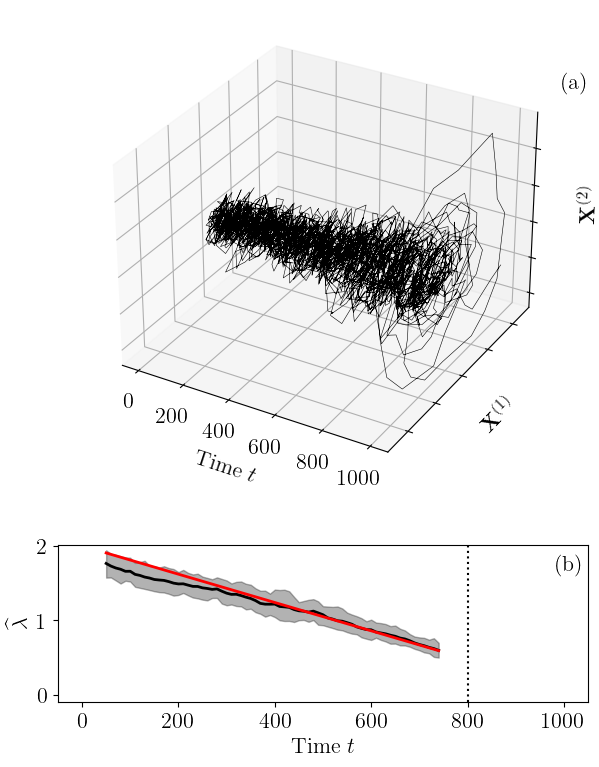

In [9]:
fig, [xyplt, eigvalplt] = plt.subplots(nrows=2, ncols=1,figsize=(3.42*2, 4.5*2),gridspec_kw={'height_ratios': [3, 1]})
props = dict(edgecolor="none", facecolor='white', alpha=0)
xyplt.remove()
xyplt = fig.add_subplot(2,1,1,projection="3d")
xyplt.plot(plt_tspan[::OneOverDelta_t//3], hopfsamplepaths[0][0][::OneOverDelta_t//3], hopfsamplepaths[0][1][::OneOverDelta_t//3], color = samplecolor, linewidth = samplelinewidth/5)
#xyplt.set_xlim([xyplt.get_xlim()[1], xyplt.get_xlim()[0]])
xyplt.set_zlabel(r"$\mathbf{X}^{(2)}$")
xyplt.set_xlabel("\n Time $t$")
xyplt.set_ylabel(r"$\mathbf{X}^{(1)}$")
#xyplt.set_xticklabels([])
xyplt.set_yticklabels([])
xyplt.set_zticklabels([])
#xyplt.text(0.94, 0.96, "(a)", transform=xyplt.transAxes, verticalalignment='top', bbox=props)
eigvalplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerhopfsamplelambda[:,0], upperhopfsamplelambda[:,0], color=pcolor, alpha = 0.3)
eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanhopfsamplelambda[:,0], color = pcolor, linewidth = theolinewidth)
#eigvalplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerhopfsamplelambda[:,1], upperhopfsamplelambda[:,1], color=eigval2color, alpha = 0.3)#####
#eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanhopfsamplelambda[:,1], color = eigval2color, linewidth = theolinewidth)#####
eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), [mu(t) for t in range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t))], color = theocolor, linewidth = theolinewidth)
eigvalplt.scatter([0,T],[meanhopfsamplelambda[0][0],meanhopfsamplelambda[0][0]],color="white")
eigvalplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
eigvalplt.set_ylabel("$\widehat{\lambda}$")
eigvalplt.set_ylim(-0.1,eigvalplt.get_ylim()[1])
eigvalplt.text(0.95, 4, "(a)", transform=eigvalplt.transAxes, verticalalignment='top', bbox=props)
eigvalplt.text(0.94, 0.94, "(b)", transform=eigvalplt.transAxes, verticalalignment='top', bbox=props)
eigvalplt.set_xlabel("Time $t$")

#[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xyplt, eigvalplt]]

#fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.1, wspace=.2)

#fig.savefig("Plots/HopfEigVals" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True) 


Text(0.5, 0, 'Time $t$')

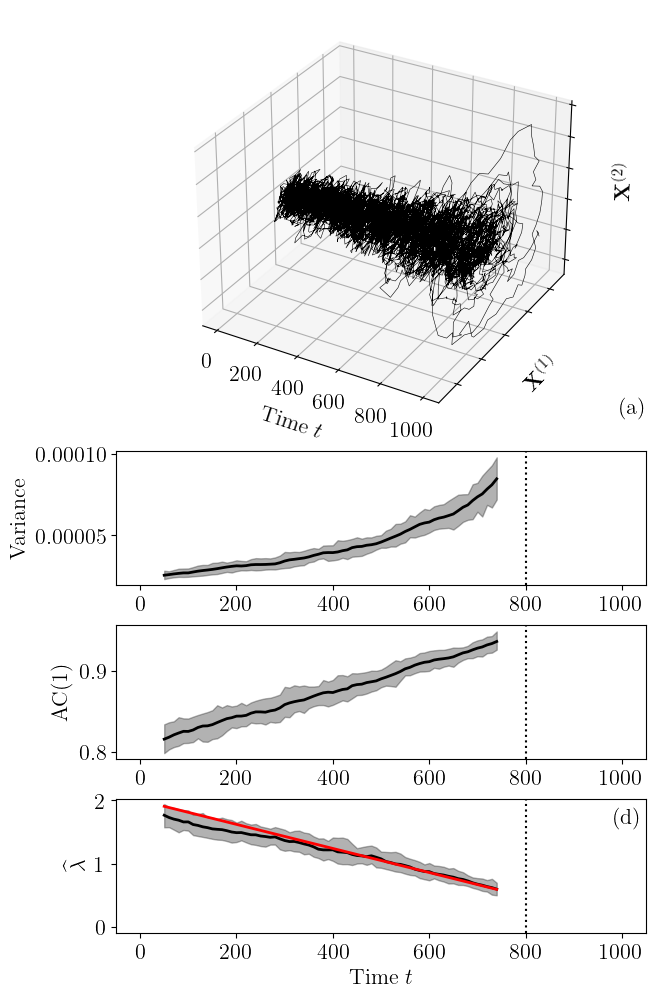

In [10]:
fig, [xyplt, varplt, ac1plt, eigvalplt] = plt.subplots(nrows=4, ncols=1,figsize=(3.42*2, 6*2),gridspec_kw={'height_ratios': [3, 1, 1, 1]})
props = dict(edgecolor="none", facecolor='white', alpha=0)
xyplt.remove()
xyplt = fig.add_subplot(2,1,1,projection="3d")
xyplt.plot(plt_tspan[::], hopfsamplepaths[0][0][::], hopfsamplepaths[0][1][::], color = samplecolor, linewidth = samplelinewidth/5)
#xyplt.set_xlim([xyplt.get_xlim()[1], xyplt.get_xlim()[0]])
xyplt.set_zlabel(r"$\mathbf{X}^{(2)}$")
xyplt.set_xlabel("\n Time $t$")
xyplt.set_ylabel(r"$\mathbf{X}^{(1)}$")
#xyplt.set_xticklabels([])
xyplt.set_yticklabels([])
xyplt.set_zticklabels([])
#xyplt.text(0.94, 0.96, "(a)", transform=xyplt.transAxes, verticalalignment='top', bbox=props)

varplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerhopfsamplevar[:], upperhopfsamplevar[:], color=pcolor, alpha = 0.3)
varplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanhopfsamplevar[:], color = pcolor, linewidth = theolinewidth)
varplt.scatter([0,T],[meanhopfsamplevar[0],meanhopfsamplevar[0]],color="white")
varplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
varplt.set_ylabel("Variance")
varplt.text(0.94, 0.94, "(b)", transform=eigvalplt.transAxes, verticalalignment='top', bbox=props)

ac1plt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerhopfsampleac1[:], upperhopfsampleac1[:], color=pcolor, alpha = 0.3)
ac1plt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanhopfsampleac1[:], color = pcolor, linewidth = theolinewidth)
ac1plt.scatter([0,T],[meanhopfsampleac1[0],meanhopfsampleac1[0]],color="white")
ac1plt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
ac1plt.set_ylabel("AC(1)")
ac1plt.text(0.94, 0.94, "(c)", transform=eigvalplt.transAxes, verticalalignment='top', bbox=props)

eigvalplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerhopfsamplelambda[:,0], upperhopfsamplelambda[:,0], color=pcolor, alpha = 0.3)
eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanhopfsamplelambda[:,0], color = pcolor, linewidth = theolinewidth)
#eigvalplt.fill_between(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), lowerhopfsamplelambda[:,1], upperhopfsamplelambda[:,1], color=eigval2color, alpha = 0.3)
#eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), meanhopfsamplelambda[:,1], color = eigval2color, linewidth = theolinewidth)
eigvalplt.plot(range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t)), [mu(t) for t in range(round(windowsize/OneOverDelta_t / 2), T_measure - round(windowsize/OneOverDelta_t / 2), round(leap/OneOverDelta_t))], color = theocolor, linewidth = theolinewidth)
eigvalplt.scatter([0,T],[meanhopfsamplelambda[0][0],meanhopfsamplelambda[0][0]],color="white")
eigvalplt.axvline(T_measure, linestyle = "dotted", color = measurecolor)
eigvalplt.set_ylabel("$\widehat{\lambda}$")
eigvalplt.set_ylim(-0.1,eigvalplt.get_ylim()[1])
eigvalplt.text(0.95, 4, "(a)", transform=eigvalplt.transAxes, verticalalignment='top', bbox=props)
eigvalplt.text(0.94, 0.94, "(d)", transform=eigvalplt.transAxes, verticalalignment='top', bbox=props)
eigvalplt.set_xlabel("Time $t$")


#[plots.yaxis.set_label_coords(-0.1,.5) for plots in [xyplt, eigvalplt]]

#fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.99, hspace=.1, wspace=.2)

#fig.savefig("Plots/HopfEigVals" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True) 


## Analysis of estimator quality

OU-data generator

In [68]:
def OU_sample(T,Delta_t,lambda_, other_lambdas=1,sigma_=1, dimensions = 1, misaligned = False):
    oversampling = 10
    int_tspan = np.linspace(0,T,round(T*oversampling/Delta_t))
    if dimensions == 1:
        A=np.array([[-lambda_]])
        B=np.array([[sigma_]])
        f=lambda x, t: np.matmul(A,x)
        G=lambda x, t: B
        x_0 = [np.random.normal(0,np.sqrt(sigma_**2/(2*lambda_)))]
        this_sample = sdeint.itoint(f, G, x_0, int_tspan)
    elif dimensions == 2:
        if misaligned:
            A=np.array([[-lambda_-other_lambdas,-lambda_+other_lambdas],[-lambda_+other_lambdas,-lambda_-other_lambdas]])/2
        else:
            A=np.array([[-lambda_,0],[0,-other_lambdas]])
        B=np.array([[sigma_,0],[0,sigma_]])#2*sigma_ in second entry
        f=lambda x, t: np.matmul(A,x)
        G=lambda x, t: B
        x_0 = np.array([0,0])##np.random.multivariate_normal([0,0],[[sigma_**2*(lambda_+other_lambdas)/(4*lambda_*other_lambdas),-sigma_**2*(lambda_-other_lambdas)/(4*lambda_*other_lambdas)],[-sigma_**2*(lambda_-other_lambdas)/(4*lambda_*other_lambdas),sigma_**2*(lambda_+other_lambdas)/(4*lambda_*other_lambdas)]])
        this_sample = sdeint.itoint(f, G, x_0, int_tspan)
    else:
        return np.zeros((dimensions, round(T/Delta_t)))
    return this_sample[::oversampling].transpose()

Calculate the 95% interval of the estimator distributions

In [69]:
def estimator_dist_width(samples, estimator, samplesize = 1000, confidence=0.95, dimensions=1):
    if estimator in [KM_EWS_methods.lambda_estimator, KM_EWS_methods.MAF_estimator]:
        estimator_results = [estimator(this_sample)[0] for this_sample in samples]
        #print(estimator_results)
    elif estimator in [KM_EWS_methods.PCA_cov_estimator, KM_EWS_methods.PCA_acov_estimator]:
        estimator_results = [estimator(this_sample)[0][-1] for this_sample in samples]
    else:
        estimator_results = [estimator(this_sample[0,:]) for this_sample in samples]
    estimator_results.sort()
    return [estimator_results[round(samplesize*(1-confidence)/2)],estimator_results[round(samplesize*(confidence+(1-confidence)/2))]]

Check in 1D for a selection of Ts and Delta_ts whether the confidence intervals overlap

In [99]:
Ts = [25, 50, 75, 100, 125, 150]
Delta_ts = [1, 0.8, 0.6, 0.4, 0.2, 0.1]
lambda_start = 1
lambda_end = 0.1
samplesize = 1000
confidence = 0.95
dimensions = 1

variance_df = [[] for i in range(len(Ts))]
ac1_df = [[] for i in range(len(Ts))]
lambda_df = [[] for i in range(len(Ts))]
for i in range(len(Ts)):
    for Delta_t in Delta_ts:
        samples_start = [OU_sample(Ts[i], Delta_t, lambda_start, dimensions=dimensions) for j in range(samplesize)]
        samples_end = [OU_sample(Ts[i], Delta_t, lambda_end, dimensions=dimensions) for j in range(samplesize)]
        variance_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.variance_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1]<estimator_dist_width(samples_end, KM_EWS_methods.variance_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0])
        ac1_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.ac1_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1]<estimator_dist_width(samples_end, KM_EWS_methods.ac1_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0])
        lambda_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0]>estimator_dist_width(samples_end, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1])

variance_df = pd.DataFrame(variance_df,index=Ts, columns=Delta_ts)
ac1_df = pd.DataFrame(ac1_df,index=Ts, columns=Delta_ts)
lambda_df = pd.DataFrame(lambda_df,index=Ts, columns=Delta_ts)

Generate a combined plot of the tests for distribution separation and one examplary distribution each

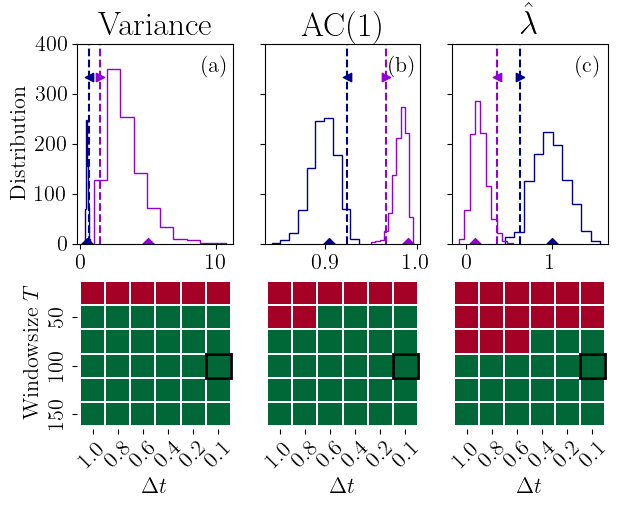

In [100]:
fig, axs = plt.subplots(2, 3, figsize=(2*3.42, 2*2.5),gridspec_kw={'height_ratios': [2, 1.5]})
axs = axs.flatten()

T = 100
Delta_t = 0.1
samplesize = 1000
estimators = [KM_EWS_methods.variance_estimator, KM_EWS_methods.ac1_estimator, KM_EWS_methods.lambda_estimator]

color_start = "darkblue"
color_end = "darkviolet"


props = dict(edgecolor="none", facecolor='white', alpha=0)
samples_start = [OU_sample(T, Delta_t, lambda_=lambda_start, dimensions=dimensions) for i in range(samplesize)]
samples_end = [OU_sample(T, Delta_t, lambda_=lambda_end, dimensions=dimensions) for i in range(samplesize)]
for i in range(3):
    if i == 2:
        estimator_results_start = np.array([estimators[i](this_sample)[0] for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample)[0] for this_sample in samples_end])
        estimator_results_end.sort()
        estimator_results_start = estimator_results_start/Delta_t
        estimator_results_end = estimator_results_end/Delta_t
        axs[i].axvline(estimator_results_start[round(samplesize*(1-confidence)/2)],color=color_start,linestyle = "dashed")
        axs[i].axvline(estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))],color=color_end,linestyle = "dashed")
        axs[i].scatter([estimator_results_start[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_start,marker=">")
        axs[i].scatter([estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_end,marker="<")
    else:
        estimator_results_start = np.array([estimators[i](this_sample[0]) for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample[0]) for this_sample in samples_end])
        estimator_results_end.sort()
        axs[i].axvline(estimator_results_end[round(samplesize*(1-confidence)/2)],color=color_end,linestyle = "dashed")
        axs[i].axvline(estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))],color=color_start,linestyle = "dashed")
        axs[i].scatter([estimator_results_end[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_end,marker=">")
        axs[i].scatter([estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_start,marker="<")
    axs[i].hist(estimator_results_start,histtype="step",color=color_start)
    axs[i].hist(estimator_results_end,histtype="step",color=color_end)
    axs[i].set_ylim([0,samplesize*0.4])
axs[0].set_title("Variance")
axs[0].scatter([1/(2*lambda_start)],[0],c=color_start,marker="D")
axs[0].scatter([1/(2*lambda_end)],[0],c=color_end,marker="D")
axs[0].set_ylabel("Distribution")
axs[0].text(0.8, 0.94, "(a)", transform=axs[0].transAxes, verticalalignment='top', bbox=props)
axs[1].set_title("AC(1)")
axs[1].scatter([np.exp(-lambda_start*Delta_t)],[0],c=color_start,marker="D")
axs[1].scatter([np.exp(-lambda_end*Delta_t)],[0],c=color_end,marker="D")
axs[1].text(0.8, 0.94, "(b)", transform=axs[1].transAxes, verticalalignment='top', bbox=props)
axs[1].set_yticklabels([])
axs[2].set_title("$\hat\lambda$")
axs[2].scatter([lambda_start],[0],c=color_start,marker="D")
axs[2].scatter([lambda_end],[0],c=color_end,marker="D")
axs[2].text(0.8, 0.94, "(c)", transform=axs[2].transAxes, verticalalignment='top', bbox=props)
axs[2].set_yticklabels([])


cmap = matplotlib.colormaps["RdYlGn"]
sns.heatmap(variance_df, ax = axs[3],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation = 45)
axs[3].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[3].set_xlim([-0.1,6.1])
axs[3].set_ylim([6.1,-0.1])
axs[3].set_yticks([1.5,3.5,5.5])
axs[3].set_yticklabels(["50","100","150"])
axs[3].set_xlabel("$\Delta t$")
axs[3].set_ylabel("Windowsize $T$")
sns.heatmap(ac1_df, ax = axs[4],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation = 45)
axs[4].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[4].set_xlim([-0.1,6.1])
axs[4].set_ylim([6.1,-0.1])
axs[4].set_xlabel("$\Delta t$")
axs[4].set_yticks([])
sns.heatmap(lambda_df, ax = axs[5],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[5].set_xticklabels(axs[5].get_xticklabels(), rotation = 45)
axs[5].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[5].set_xlim([-0.1,6.1])
axs[5].set_ylim([6.1,-0.1])
axs[5].set_xlabel("$\Delta t$")
axs[5].set_yticks([])




plt.show()
#fig.savefig("Plots/EstimatorDistributionAndSensitivity" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches='tight')

Check in 2D for a selection of Ts and Delta_ts whether the confidence intervals overlap

First for an example where an observed dimension is aligned with the CSD dimension

In [85]:
Ts = [25, 50, 75, 100, 125, 150]
Delta_ts = [1, 0.8, 0.6, 0.4, 0.2, 0.1]
lambda_start = 3
lambda_end = 1
samplesize = 1000
confidence = 0.95
dimensions = 2

variance_df = [[] for i in range(len(Ts))]
ac1_df = [[] for i in range(len(Ts))]
lambda_df = [[] for i in range(len(Ts))]
for i in range(len(Ts)):
    for Delta_t in Delta_ts:
        samples_start = [OU_sample(Ts[i], Delta_t, lambda_start, dimensions=dimensions, misaligned=False) for j in range(samplesize)]
        samples_end = [OU_sample(Ts[i], Delta_t, lambda_end, dimensions=dimensions, misaligned=False) for j in range(samplesize)]
        variance_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.variance_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1]<estimator_dist_width(samples_end, KM_EWS_methods.variance_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0])
        ac1_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.ac1_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1]<estimator_dist_width(samples_end, KM_EWS_methods.ac1_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0])
        lambda_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0]>estimator_dist_width(samples_end, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1])

variance_df = pd.DataFrame(variance_df,index=Ts, columns=Delta_ts)
ac1_df = pd.DataFrame(ac1_df,index=Ts, columns=Delta_ts)
lambda_df = pd.DataFrame(lambda_df,index=Ts, columns=Delta_ts)

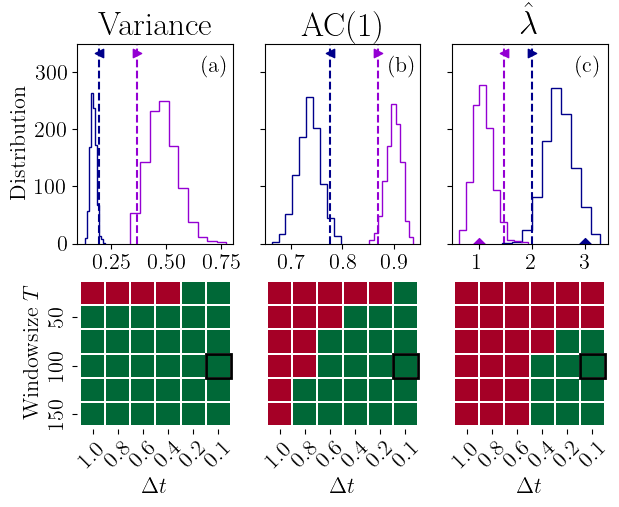

In [96]:
fig, axs = plt.subplots(2, 3, figsize=(2*3.42, 2*2.5),gridspec_kw={'height_ratios': [2, 1.5]})
axs = axs.flatten()

T = 100
Delta_t = 0.1
samplesize = 1000
estimators = [KM_EWS_methods.variance_estimator, KM_EWS_methods.ac1_estimator, KM_EWS_methods.lambda_estimator]

color_start = "darkblue"
color_end = "darkviolet"


props = dict(edgecolor="none", facecolor='white', alpha=0)
samples_start = [OU_sample(T, Delta_t, lambda_=lambda_start, dimensions=dimensions, misaligned=False) for i in range(samplesize)]
samples_end = [OU_sample(T, Delta_t, lambda_=lambda_end, dimensions=dimensions, misaligned=False) for i in range(samplesize)]
for i in range(3):
    if i in [2]:
        estimator_results_start = np.array([estimators[i](this_sample)[0] for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample)[0] for this_sample in samples_end])
        estimator_results_end.sort()
        estimator_results_start = estimator_results_start/Delta_t
        estimator_results_end = estimator_results_end/Delta_t
        axs[i].axvline(estimator_results_start[round(samplesize*(1-confidence)/2)],color=color_start,linestyle = "dashed")
        axs[i].axvline(estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))],color=color_end,linestyle = "dashed")
        axs[i].scatter([estimator_results_start[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_start,marker=">")
        axs[i].scatter([estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_end,marker="<")
    else:
        estimator_results_start = np.array([estimators[i](this_sample[0]) for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample[0]) for this_sample in samples_end])
        estimator_results_end.sort()
        axs[i].axvline(estimator_results_end[round(samplesize*(1-confidence)/2)],color=color_end,linestyle = "dashed")
        axs[i].axvline(estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))],color=color_start,linestyle = "dashed")
        axs[i].scatter([estimator_results_end[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_end,marker=">")
        axs[i].scatter([estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_start,marker="<")
    axs[i].hist(estimator_results_start,histtype="step",color=color_start)
    axs[i].hist(estimator_results_end,histtype="step",color=color_end)
    #axs[i].set_ylim([0,samplesize*0.4])
axs[0].set_title("Variance")
#axs[0].scatter([1/(2*lambda_start)],[0],c=color_start,marker="D")
#axs[0].scatter([1/(2*lambda_end)],[0],c=color_end,marker="D")
axs[0].set_ylabel("Distribution")
axs[0].text(0.8, 0.94, "(a)", transform=axs[0].transAxes, verticalalignment='top', bbox=props)
axs[1].set_title("AC(1)")
#axs[1].scatter([np.exp(-lambda_start*Delta_t)],[0],c=color_start,marker="D")
#axs[1].scatter([np.exp(-lambda_end*Delta_t)],[0],c=color_end,marker="D")
axs[1].text(0.8, 0.94, "(b)", transform=axs[1].transAxes, verticalalignment='top', bbox=props)
axs[1].set_yticklabels([])
axs[2].set_title("$\hat\lambda$")
axs[2].scatter([lambda_start],[0],c=color_start,marker="D")
axs[2].scatter([lambda_end],[0],c=color_end,marker="D")
axs[2].text(0.8, 0.94, "(c)", transform=axs[2].transAxes, verticalalignment='top', bbox=props)
axs[2].set_yticklabels([])


cmap = matplotlib.colormaps["RdYlGn"]
sns.heatmap(variance_df, ax = axs[3],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation = 45)
axs[3].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[3].set_xlim([-0.1,6.1])
axs[3].set_ylim([6.1,-0.1])
axs[3].set_yticks([1.5,3.5,5.5])
axs[3].set_yticklabels(["50","100","150"])
axs[3].set_xlabel("$\Delta t$")
axs[3].set_ylabel("Windowsize $T$")
sns.heatmap(ac1_df, ax = axs[4],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation = 45)
axs[4].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[4].set_xlim([-0.1,6.1])
axs[4].set_ylim([6.1,-0.1])
axs[4].set_xlabel("$\Delta t$")
axs[4].set_yticks([])
sns.heatmap(lambda_df, ax = axs[5],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[5].set_xticklabels(axs[5].get_xticklabels(), rotation = 45)
axs[5].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[5].set_xlim([-0.1,6.1])
axs[5].set_ylim([6.1,-0.1])
axs[5].set_xlabel("$\Delta t$")
axs[5].set_yticks([])




plt.show()
#fig.savefig("Plots/EstimatorDistributionAndSensitivity" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches='tight')

Then for an example where the observed dimesnions are misaligned with the CSD dimension

In [97]:
Ts = [25, 50, 75, 100, 125, 150]
Delta_ts = [1, 0.8, 0.6, 0.4, 0.2, 0.1]
lambda_start = 3
lambda_end = 1
samplesize = 1000
confidence = 0.95
dimensions = 2

variance_df = [[] for i in range(len(Ts))]
ac1_df = [[] for i in range(len(Ts))]
lambda_df = [[] for i in range(len(Ts))]
for i in range(len(Ts)):
    for Delta_t in Delta_ts:
        samples_start = [OU_sample(Ts[i], Delta_t, lambda_start, dimensions=dimensions, misaligned=True) for j in range(samplesize)]
        samples_end = [OU_sample(Ts[i], Delta_t, lambda_end, dimensions=dimensions, misaligned=True) for j in range(samplesize)]
        variance_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.variance_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1]<estimator_dist_width(samples_end, KM_EWS_methods.variance_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0])
        ac1_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.ac1_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1]<estimator_dist_width(samples_end, KM_EWS_methods.ac1_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0])
        lambda_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0]>estimator_dist_width(samples_end, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1])

variance_df = pd.DataFrame(variance_df,index=Ts, columns=Delta_ts)
ac1_df = pd.DataFrame(ac1_df,index=Ts, columns=Delta_ts)
lambda_df = pd.DataFrame(lambda_df,index=Ts, columns=Delta_ts)

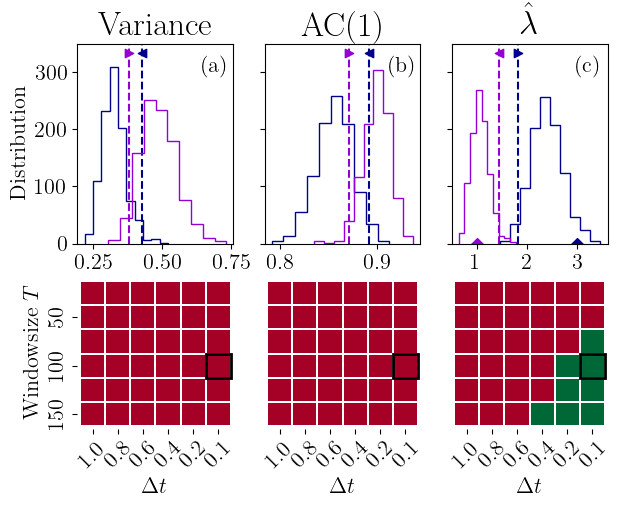

In [98]:
fig, axs = plt.subplots(2, 3, figsize=(2*3.42, 2*2.5),gridspec_kw={'height_ratios': [2, 1.5]})
axs = axs.flatten()

T = 100
Delta_t = 0.1
samplesize = 1000
estimators = [KM_EWS_methods.variance_estimator, KM_EWS_methods.ac1_estimator, KM_EWS_methods.lambda_estimator]

color_start = "darkblue"
color_end = "darkviolet"


props = dict(edgecolor="none", facecolor='white', alpha=0)
samples_start = [OU_sample(T, Delta_t, lambda_=lambda_start, dimensions=dimensions, misaligned=True) for i in range(samplesize)]
samples_end = [OU_sample(T, Delta_t, lambda_=lambda_end, dimensions=dimensions, misaligned=True) for i in range(samplesize)]
for i in range(3):
    if i in [2]:
        estimator_results_start = np.array([estimators[i](this_sample)[0] for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample)[0] for this_sample in samples_end])
        estimator_results_end.sort()
        estimator_results_start = estimator_results_start/Delta_t
        estimator_results_end = estimator_results_end/Delta_t
        axs[i].axvline(estimator_results_start[round(samplesize*(1-confidence)/2)],color=color_start,linestyle = "dashed")
        axs[i].axvline(estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))],color=color_end,linestyle = "dashed")
        axs[i].scatter([estimator_results_start[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_start,marker=">")
        axs[i].scatter([estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_end,marker="<")
    else:
        estimator_results_start = np.array([estimators[i](this_sample[0]) for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample[0]) for this_sample in samples_end])
        estimator_results_end.sort()
        axs[i].axvline(estimator_results_end[round(samplesize*(1-confidence)/2)],color=color_end,linestyle = "dashed")
        axs[i].axvline(estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))],color=color_start,linestyle = "dashed")
        axs[i].scatter([estimator_results_end[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_end,marker=">")
        axs[i].scatter([estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_start,marker="<")
    axs[i].hist(estimator_results_start,histtype="step",color=color_start)
    axs[i].hist(estimator_results_end,histtype="step",color=color_end)
    #axs[i].set_ylim([0,samplesize*0.4])
axs[0].set_title("Variance")
#axs[0].scatter([1/(2*lambda_start)],[0],c=color_start,marker="D")
#axs[0].scatter([1/(2*lambda_end)],[0],c=color_end,marker="D")
axs[0].set_ylabel("Distribution")
axs[0].text(0.8, 0.94, "(a)", transform=axs[0].transAxes, verticalalignment='top', bbox=props)
axs[1].set_title("AC(1)")
#axs[1].scatter([np.exp(-lambda_start*Delta_t)],[0],c=color_start,marker="D")
#axs[1].scatter([np.exp(-lambda_end*Delta_t)],[0],c=color_end,marker="D")
axs[1].text(0.8, 0.94, "(b)", transform=axs[1].transAxes, verticalalignment='top', bbox=props)
axs[1].set_yticklabels([])
axs[2].set_title("$\hat\lambda$")
axs[2].scatter([lambda_start],[0],c=color_start,marker="D")
axs[2].scatter([lambda_end],[0],c=color_end,marker="D")
axs[2].text(0.8, 0.94, "(c)", transform=axs[2].transAxes, verticalalignment='top', bbox=props)
axs[2].set_yticklabels([])


cmap = matplotlib.colormaps["RdYlGn"]
sns.heatmap(variance_df, ax = axs[3],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation = 45)
axs[3].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[3].set_xlim([-0.1,6.1])
axs[3].set_ylim([6.1,-0.1])
axs[3].set_yticks([1.5,3.5,5.5])
axs[3].set_yticklabels(["50","100","150"])
axs[3].set_xlabel("$\Delta t$")
axs[3].set_ylabel("Windowsize $T$")
sns.heatmap(ac1_df, ax = axs[4],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation = 45)
axs[4].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[4].set_xlim([-0.1,6.1])
axs[4].set_ylim([6.1,-0.1])
axs[4].set_xlabel("$\Delta t$")
axs[4].set_yticks([])
sns.heatmap(lambda_df, ax = axs[5],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[5].set_xticklabels(axs[5].get_xticklabels(), rotation = 45)
axs[5].add_patch(Rectangle((5,3),1,1,fill=False,edgecolor="black", lw=2))
axs[5].set_xlim([-0.1,6.1])
axs[5].set_ylim([6.1,-0.1])
axs[5].set_xlabel("$\Delta t$")
axs[5].set_yticks([])


plt.show()
#fig.savefig("Plots/EstimatorDistributionAndSensitivity" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches='tight')

Testing the PCA or MAF method

In [ ]:
Ts = [50, 75, 100, 125, 150]
Delta_ts = [1, 0.8, 0.6, 0.4, 0.2, 0.1]
lambda_start = 3
lambda_end = 1
samplesize = 1000
confidence = 0.95
dimensions = 2

variance_df = [[] for i in range(len(Ts))]
ac1_df = [[] for i in range(len(Ts))]
lambda_df = [[] for i in range(len(Ts))]
for i in range(len(Ts)):
    for Delta_t in Delta_ts:
        samples_start = [OU_sample(Ts[i], Delta_t, lambda_start, dimensions=dimensions, misaligned=True) for j in range(samplesize)]
        samples_end = [OU_sample(Ts[i], Delta_t, lambda_end, dimensions=dimensions, misaligned=True) for j in range(samplesize)]
        variance_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.PCA_cov_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1]<estimator_dist_width(samples_end, KM_EWS_methods.PCA_cov_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0])
        ac1_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.MAF_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0]>estimator_dist_width(samples_end, KM_EWS_methods.MAF_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1])
        lambda_df[i].append(estimator_dist_width(samples_start, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[0]>estimator_dist_width(samples_end, KM_EWS_methods.lambda_estimator, samplesize=samplesize, confidence=confidence, dimensions=dimensions)[1])

variance_df = pd.DataFrame(variance_df,index=Ts, columns=Delta_ts)
ac1_df = pd.DataFrame(ac1_df,index=Ts, columns=Delta_ts)
lambda_df = pd.DataFrame(lambda_df,index=Ts, columns=Delta_ts)
fig, axs = plt.subplots(2, 3, figsize=(2*3.42, 2*2.5),gridspec_kw={'height_ratios': [2, 1.2]})
axs = axs.flatten()

T = 100
Delta_t = 0.1
samplesize = 1000
estimators = [KM_EWS_methods.PCA_cov_estimator, KM_EWS_methods.MAF_estimator, KM_EWS_methods.lambda_estimator]

color_start = "darkblue"
color_end = "darkviolet"


props = dict(edgecolor="none", facecolor='white', alpha=0)
samples_start = [OU_sample(T, Delta_t, lambda_=lambda_start, dimensions=dimensions, misaligned=True) for i in range(samplesize)]
samples_end = [OU_sample(T, Delta_t, lambda_=lambda_end, dimensions=dimensions, misaligned=True) for i in range(samplesize)]
for i in range(3):
    if i in [1,2]:
        estimator_results_start = np.array([estimators[i](this_sample)[0] for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample)[0] for this_sample in samples_end])
        estimator_results_end.sort()
        estimator_results_start = estimator_results_start/Delta_t
        estimator_results_end = estimator_results_end/Delta_t
        #axs[i].axvline(estimator_results_start[round(samplesize*(1-confidence)/2)],color=color_start,linestyle = "dashed")
        #axs[i].axvline(estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))],color=color_end,linestyle = "dashed")
        #axs[i].scatter([estimator_results_start[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_start,marker=">")
        #axs[i].scatter([estimator_results_end[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_end,marker="<")
    else:
        estimator_results_start = np.array([estimators[i](this_sample)[-1] for this_sample in samples_start])
        estimator_results_start.sort()
        estimator_results_end = np.array([estimators[i](this_sample)[-1] for this_sample in samples_end])
        estimator_results_end.sort()
        #axs[i].axvline(estimator_results_end[round(samplesize*(1-confidence)/2)],color=color_end,linestyle = "dashed")
        #axs[i].axvline(estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))],color=color_start,linestyle = "dashed")
        #axs[i].scatter([estimator_results_end[round(samplesize*(1-confidence)/2)]],[samplesize/3],c=color_end,marker=">")
        #axs[i].scatter([estimator_results_start[round(samplesize*(confidence+(1-confidence)/2))]],[samplesize/3],c=color_start,marker="<")
    #axs[i].hist(estimator_results_start,histtype="step",color=color_start)
    #axs[i].hist(estimator_results_end,histtype="step",color=color_end)
    #axs[i].set_ylim([0,samplesize*0.4])
axs[0].set_title("Variance")
axs[0].scatter([1/(2*lambda_start)],[0],c=color_start,marker="D")
axs[0].scatter([1/(2*lambda_end)],[0],c=color_end,marker="D")
axs[0].set_ylabel("Distribution")
axs[0].text(0.8, 0.94, "(a)", transform=axs[0].transAxes, verticalalignment='top', bbox=props)
axs[1].set_title("AC(1)")
axs[1].scatter([np.exp(-lambda_start*Delta_t)],[0],c=color_start,marker="D")
axs[1].scatter([np.exp(-lambda_end*Delta_t)],[0],c=color_end,marker="D")
axs[1].text(0.8, 0.94, "(b)", transform=axs[1].transAxes, verticalalignment='top', bbox=props)
axs[1].set_yticklabels([])
axs[2].set_title("$\hat\lambda$")
axs[2].scatter([lambda_start],[0],c=color_start,marker="D")
axs[2].scatter([lambda_end],[0],c=color_end,marker="D")
axs[2].text(0.8, 0.94, "(c)", transform=axs[2].transAxes, verticalalignment='top', bbox=props)
axs[2].set_yticklabels([])


cmap = matplotlib.colormaps["RdYlGn"]
sns.heatmap(variance_df, ax = axs[3],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation = 45)
axs[3].add_patch(Rectangle((5,2),1,1,fill=False,edgecolor="black", lw=2))
axs[3].set_xlim([-0.1,6.1])
axs[3].set_ylim([5.1,-0.1])
axs[3].set_xlabel("$\Delta t$")
axs[3].set_ylabel("Windowsize")
sns.heatmap(ac1_df, ax = axs[4],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation = 45)
axs[4].add_patch(Rectangle((5,2),1,1,fill=False,edgecolor="black", lw=2))
axs[4].set_xlim([-0.1,6.1])
axs[4].set_ylim([5.1,-0.1])
axs[4].set_xlabel("$\Delta t$")
axs[4].set_yticks([])
sns.heatmap(lambda_df, ax = axs[5],cbar=False, cmap=cmap, vmin=0, vmax=1, linewidths=0.01)
axs[5].set_xticklabels(axs[5].get_xticklabels(), rotation = 45)
axs[5].add_patch(Rectangle((5,2),1,1,fill=False,edgecolor="black", lw=2))
axs[5].set_xlim([-0.1,6.1])
axs[5].set_ylim([5.1,-0.1])
axs[5].set_xlabel("$\Delta t$")
axs[5].set_yticks([])




plt.show()
#fig.savefig("Plots/EstimatorDistributionAndSensitivity" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches='tight')